In [1]:
import pandas as pd

df = pd.read_csv('../Dataset/FeatureEngineering_T2M_data.csv')
df.tail()

,date,tsoil1,tsoil2,tsoil3,tsoil4,t2m,t2m_max,t2m_min,t10m,t10m_max,...,t2m_volatility_3d_lag3,t2m_anomaly_lag1,t2m_anomaly_lag2,t2m_anomaly_lag3,temp_gradient_surface_lag1,temp_gradient_surface_lag2,temp_gradient_surface_lag3,wind_chill_factor_lag1,wind_chill_factor_lag2,wind_chill_factor_lag3
16364,2025-11-10,27.22,26.89,26.45,26.50,27.96,30.47,26.15,28.21,30.25,...,0.018506,1.599108,0.979108,0.219108,-0.38,-0.18,-0.26,27.609,27.039,26.639
16365,2025-11-11,27.18,26.98,26.62,26.53,27.73,30.78,25.67,27.92,30.65,...,0.019798,1.779108,1.599108,0.979108,-0.21,-0.38,-0.18,27.944,27.609,27.039
16366,2025-11-12,27.33,27.01,26.71,26.56,28.32,31.13,25.87,28.64,31.10,...,0.025492,1.549108,1.779108,1.599108,-0.17,-0.21,-0.38,27.671,27.944,27.609
16367,2025-11-13,26.98,27.10,26.82,26.59,27.32,29.18,25.70,27.44,29.09,...,0.015188,2.139108,1.549108,1.779108,-0.07,-0.17,-0.21,28.244,27.671,27.944
16368,2025-11-14,25.64,26.43,26.78,26.63,25.75,28.15,23.67,25.84,28.22,...,0.004348,1.139108,2.139108,1.549108,-0.17,-0.07,-0.17,27.398,28.244,27.671


In [2]:
len(df.columns)

399

### X, y and Train / Test for Time Series

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [4]:
H = 7
t2m_targets = [f"t2m_d{h}_forecast" for h in range(1, H+1)]

In [5]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

feature_cols = [c for c in num_cols if c not in t2m_targets]

print("Number of features:", len(feature_cols))
print("Targets:", t2m_targets)

Number of features: 391
Targets: ['t2m_d1_forecast', 't2m_d2_forecast', 't2m_d3_forecast', 't2m_d4_forecast', 't2m_d5_forecast', 't2m_d6_forecast', 't2m_d7_forecast']


In [6]:
X = df[feature_cols]         # shape = (n_samples, n_features)
Y = df[t2m_targets]           # shape = (n_samples, 7)

In [7]:
test_ratio = 0.1
n_samples = len(df)
split_idx = int(n_samples * (1 - test_ratio))

# split
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
Y_train, Y_test = Y.iloc[:split_idx], Y.iloc[split_idx:]

print("Train size:", X_train.shape, Y_train.shape)
print("Test  size:", X_test.shape, Y_test.shape)

Train size: (14732, 391) (14732, 7)
Test  size: (1637, 391) (1637, 7)


### Train LightGBM (Multi-Output)

In [8]:
%pip install lightgbm optuna tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### feature importance

In [9]:
from lightgbm import LGBMRegressor

t2m_last_col = Y_train.columns[-1]

fs_model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=63,
    random_state=42,
    n_jobs=-1
)

fs_model.fit(X_train, Y_train[t2m_last_col])

# ดึง feature importance
importances = pd.Series(fs_model.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)

# เลือก top-k features
TOP_K = 200  
selected_features = importances.head(TOP_K).index.tolist()

print(f"Selected top {TOP_K} features from LightGBM importance:")
print(selected_features)

X_train_fs = X_train[selected_features].copy()
X_test_fs  = X_test[selected_features].copy()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87228
[LightGBM] [Info] Number of data points in the train set: 14732, number of used features: 391
[LightGBM] [Info] Start training from score 27.870432
Selected top 200 features from LightGBM importance:
['month_progress', 'gwettop_roll7_std', 'dayofyear', 'doy_sin', 'tsoil4_roll7_std', 't2m_trend_strength', 'tsoil3_roll7_std', 'ts_max_roll7_std', 'rhoa_roll3_std', 'to3_lag7', 'to3', 'tsoil4_lag7', 'ts_min_roll7_std', 'gwettop_roll3_std', 'doy_cos', 't2mwet_roll7_std', 'v2m_roll7_std', 'tsoil4_roll3_std', 'rhoa_roll7_std', 'gwetprof_roll7_std', 'to3_lag3', 't2m_max_roll7_std', 'tsoil4', 't10m_min_roll7_std', 't10m_max_roll7_std', 't2m_min_roll7_std', 'tsoil3_lag7', 'to3_lag1', 'v50m_roll7_std', 'gwetroot_roll7_std', 'to3_lag6', 'gwetprof_roll3_std', 'to3_lag2', 'ts_min_roll3_std', 'to3_lag4', 'te

In [10]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from tqdm.auto import tqdm

# Create validation split for optuna
val_ratio = 0.2
val_split_idx = int(len(X_train_fs) * (1 - val_ratio))

X_train_opt = X_train_fs.iloc[:val_split_idx]
Y_train_opt = Y_train.iloc[:val_split_idx]
X_val_opt   = X_train_fs.iloc[val_split_idx:]
Y_val_opt   = Y_train.iloc[val_split_idx:]

print("Optuna train size:", X_train_opt.shape, Y_train_opt.shape)
print("Optuna val   size:", X_val_opt.shape,   Y_val_opt.shape)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.6, 0.8, 1.0]),
        'random_state': 42,
        'n_jobs': -1
    }
    
    # Create model
    base_rf = RandomForestRegressor(**params)
    model = MultiOutputRegressor(base_rf)
    
    # Train on training data
    model.fit(X_train_opt, Y_train_opt)
    
    # Predict on validation data
    Y_pred_val = model.predict(X_val_opt)
    
    # Calculate RMSE (objective to minimize)
    rmse = sqrt(mean_squared_error(Y_val_opt, Y_pred_val))
    
    return rmse

# Run Optuna optimization with built-in progress bar
study = optuna.create_study(direction='minimize', 
                           study_name='rf_t2m_forecast',
                           sampler=optuna.samplers.TPESampler(seed=42))

study.optimize(objective, 
               n_trials=100,
               timeout=5400,  # timeout
               show_progress_bar=True)

# Print best results
print(f"Best RMSE: {study.best_value:.4f}")
print(f"Best parameters:")
for key, value in study.best_params.items():
    print(f"   {key}: {value}")

# Train final model with best parameters
best_params = study.best_params
best_params.update({
    'random_state': 42,
    'n_jobs': -1
})

c:\Users\09350\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-11-25 16:29:48,122] A new study created in memory with name: rf_t2m_forecast


Optuna train size: (11785, 200) (11785, 7)
Optuna val   size: (2947, 200) (2947, 7)


Best trial: 0. Best value: 1.10787:   1%|          | 1/100 [07:34<12:30:06, 454.61s/it, 454.61/5400 seconds]

[I 2025-11-25 16:37:22,733] Trial 0 finished with value: 1.1078657781923484 and parameters: {'n_estimators': 437, 'max_depth': 15, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 0.8}. Best is trial 0 with value: 1.1078657781923484.


Best trial: 0. Best value: 1.10787:   2%|▏         | 2/100 [11:03<8:26:44, 310.25s/it, 663.80/5400 seconds] 

[I 2025-11-25 16:40:51,925] Trial 1 finished with value: 1.1673094812025955 and parameters: {'n_estimators': 737, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 1.0}. Best is trial 0 with value: 1.1078657781923484.


Best trial: 0. Best value: 1.10787:   3%|▎         | 3/100 [15:16<7:39:19, 284.12s/it, 916.83/5400 seconds]

[I 2025-11-25 16:45:04,949] Trial 2 finished with value: 1.1105705700182724 and parameters: {'n_estimators': 489, 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 0.8}. Best is trial 0 with value: 1.1078657781923484.


Best trial: 3. Best value: 1.10761:   4%|▍         | 4/100 [23:28<9:45:47, 366.11s/it, 1408.64/5400 seconds]

[I 2025-11-25 16:53:16,766] Trial 3 finished with value: 1.1076107730362441 and parameters: {'n_estimators': 563, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 0.8}. Best is trial 3 with value: 1.1076107730362441.


Best trial: 3. Best value: 1.10761:   5%|▌         | 5/100 [25:21<7:15:05, 274.79s/it, 1521.52/5400 seconds]

[I 2025-11-25 16:55:09,640] Trial 4 finished with value: 1.1296210297884526 and parameters: {'n_estimators': 374, 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_features': 0.8}. Best is trial 3 with value: 1.1076107730362441.


Best trial: 3. Best value: 1.10761:   6%|▌         | 6/100 [25:40<4:54:16, 187.84s/it, 1540.56/5400 seconds]

[I 2025-11-25 16:55:28,681] Trial 5 finished with value: 1.1133658407646672 and parameters: {'n_estimators': 696, 'max_depth': 7, 'min_samples_split': 11, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 3 with value: 1.1076107730362441.


Best trial: 3. Best value: 1.10761:   7%|▋         | 7/100 [40:27<10:45:20, 416.35s/it, 2427.38/5400 seconds]

[I 2025-11-25 17:10:15,500] Trial 6 finished with value: 1.1130817902483598 and parameters: {'n_estimators': 638, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 1.0}. Best is trial 3 with value: 1.1076107730362441.


Best trial: 3. Best value: 1.10761:   8%|▊         | 8/100 [42:58<8:29:01, 331.97s/it, 2578.69/5400 seconds] 

[I 2025-11-25 17:12:46,811] Trial 7 finished with value: 1.1091268349150898 and parameters: {'n_estimators': 421, 'max_depth': 6, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 0.6}. Best is trial 3 with value: 1.1076107730362441.


Best trial: 3. Best value: 1.10761:   9%|▉         | 9/100 [44:56<6:42:08, 265.15s/it, 2696.90/5400 seconds]

[I 2025-11-25 17:14:45,023] Trial 8 finished with value: 1.1105851113667262 and parameters: {'n_estimators': 104, 'max_depth': 13, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 1.0}. Best is trial 3 with value: 1.1076107730362441.


Best trial: 3. Best value: 1.10761:  10%|█         | 10/100 [50:57<7:21:54, 294.61s/it, 3057.47/5400 seconds]

[I 2025-11-25 17:20:45,596] Trial 9 finished with value: 1.1084975825350658 and parameters: {'n_estimators': 661, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 0.8}. Best is trial 3 with value: 1.1076107730362441.


Best trial: 10. Best value: 1.10292:  11%|█         | 11/100 [52:07<5:34:51, 225.75s/it, 3127.08/5400 seconds]

[I 2025-11-25 17:21:55,203] Trial 10 finished with value: 1.1029231831779995 and parameters: {'n_estimators': 951, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 10 with value: 1.1029231831779995.


Best trial: 10. Best value: 1.10292:  12%|█▏        | 12/100 [53:15<4:20:42, 177.75s/it, 3195.05/5400 seconds]

[I 2025-11-25 17:23:03,177] Trial 11 finished with value: 1.1030083426480448 and parameters: {'n_estimators': 917, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 10 with value: 1.1029231831779995.


Best trial: 12. Best value: 1.10292:  13%|█▎        | 13/100 [54:35<3:35:01, 148.30s/it, 3275.58/5400 seconds]

[I 2025-11-25 17:24:23,705] Trial 12 finished with value: 1.1029189579274656 and parameters: {'n_estimators': 994, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 12 with value: 1.1029189579274656.


Best trial: 12. Best value: 1.10292:  14%|█▍        | 14/100 [55:58<3:04:16, 128.57s/it, 3358.55/5400 seconds]

[I 2025-11-25 17:25:46,675] Trial 13 finished with value: 1.1029865944631365 and parameters: {'n_estimators': 973, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 12 with value: 1.1029189579274656.


Best trial: 14. Best value: 1.10275:  15%|█▌        | 15/100 [57:00<2:33:43, 108.52s/it, 3420.61/5400 seconds]

[I 2025-11-25 17:26:48,730] Trial 14 finished with value: 1.1027466580752945 and parameters: {'n_estimators': 845, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 14 with value: 1.1027466580752945.


Best trial: 14. Best value: 1.10275:  16%|█▌        | 16/100 [58:03<2:12:47, 94.85s/it, 3483.71/5400 seconds] 

[I 2025-11-25 17:27:51,830] Trial 15 finished with value: 1.1028861201230153 and parameters: {'n_estimators': 814, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 14 with value: 1.1027466580752945.


Best trial: 14. Best value: 1.10275:  17%|█▋        | 17/100 [59:06<1:57:52, 85.21s/it, 3546.51/5400 seconds]

[I 2025-11-25 17:28:54,632] Trial 16 finished with value: 1.102820192110072 and parameters: {'n_estimators': 820, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 14 with value: 1.1027466580752945.


Best trial: 14. Best value: 1.10275:  18%|█▊        | 18/100 [59:38<1:34:26, 69.11s/it, 3578.13/5400 seconds]

[I 2025-11-25 17:29:26,247] Trial 17 finished with value: 1.1100507939893007 and parameters: {'n_estimators': 827, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 14 with value: 1.1027466580752945.


Best trial: 14. Best value: 1.10275:  19%|█▉        | 19/100 [1:08:07<4:31:49, 201.35s/it, 4087.55/5400 seconds]

[I 2025-11-25 17:37:55,674] Trial 18 finished with value: 1.107003409556494 and parameters: {'n_estimators': 808, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.6}. Best is trial 14 with value: 1.1027466580752945.


Best trial: 14. Best value: 1.10275:  20%|██        | 20/100 [1:08:17<3:11:40, 143.76s/it, 4097.08/5400 seconds]

[I 2025-11-25 17:38:05,204] Trial 19 finished with value: 1.1170453736539574 and parameters: {'n_estimators': 205, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 14 with value: 1.1027466580752945.


Best trial: 20. Best value: 1.10273:  21%|██        | 21/100 [1:09:25<2:39:41, 121.28s/it, 4165.96/5400 seconds]

[I 2025-11-25 17:39:14,084] Trial 20 finished with value: 1.102730549460957 and parameters: {'n_estimators': 888, 'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 20 with value: 1.102730549460957.


Best trial: 20. Best value: 1.10273:  22%|██▏       | 22/100 [1:10:30<2:15:40, 104.36s/it, 4230.86/5400 seconds]

[I 2025-11-25 17:40:18,984] Trial 21 finished with value: 1.102734885185175 and parameters: {'n_estimators': 878, 'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 20 with value: 1.102730549460957.


Best trial: 20. Best value: 1.10273:  23%|██▎       | 23/100 [1:11:33<1:57:56, 91.91s/it, 4293.72/5400 seconds] 

[I 2025-11-25 17:41:21,841] Trial 22 finished with value: 1.1029840243934823 and parameters: {'n_estimators': 894, 'max_depth': 8, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 20 with value: 1.102730549460957.


Best trial: 20. Best value: 1.10273:  24%|██▍       | 24/100 [1:12:39<1:46:40, 84.21s/it, 4359.99/5400 seconds]

[I 2025-11-25 17:42:28,108] Trial 23 finished with value: 1.103284540737117 and parameters: {'n_estimators': 743, 'max_depth': 10, 'min_samples_split': 18, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 20 with value: 1.102730549460957.


Best trial: 20. Best value: 1.10273:  25%|██▌       | 25/100 [1:13:38<1:35:46, 76.61s/it, 4418.87/5400 seconds]

[I 2025-11-25 17:43:26,993] Trial 24 finished with value: 1.1032045572788176 and parameters: {'n_estimators': 879, 'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 20 with value: 1.102730549460957.


Best trial: 20. Best value: 1.10273:  26%|██▌       | 26/100 [1:19:30<3:16:16, 159.14s/it, 4770.56/5400 seconds]

[I 2025-11-25 17:49:18,680] Trial 25 finished with value: 1.1066897899414878 and parameters: {'n_estimators': 574, 'max_depth': 10, 'min_samples_split': 18, 'min_samples_leaf': 6, 'max_features': 0.6}. Best is trial 20 with value: 1.102730549460957.


Best trial: 20. Best value: 1.10273:  27%|██▋       | 27/100 [1:20:15<2:32:04, 125.00s/it, 4815.88/5400 seconds]

[I 2025-11-25 17:50:04,007] Trial 26 finished with value: 1.1050695696516275 and parameters: {'n_estimators': 873, 'max_depth': 7, 'min_samples_split': 17, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 20 with value: 1.102730549460957.


Best trial: 20. Best value: 1.10273:  28%|██▊       | 28/100 [1:20:46<1:56:08, 96.78s/it, 4846.84/5400 seconds] 

[I 2025-11-25 17:50:34,960] Trial 27 finished with value: 1.1079412463778775 and parameters: {'n_estimators': 748, 'max_depth': 12, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 20 with value: 1.102730549460957.


Best trial: 20. Best value: 1.10273:  29%|██▉       | 29/100 [1:21:28<1:35:06, 80.37s/it, 4888.91/5400 seconds]

[I 2025-11-25 17:51:17,031] Trial 28 finished with value: 1.1032904682853748 and parameters: {'n_estimators': 635, 'max_depth': 9, 'min_samples_split': 13, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 20 with value: 1.102730549460957.


Best trial: 20. Best value: 1.10273:  30%|███       | 30/100 [1:21:57<1:15:31, 64.74s/it, 4917.17/5400 seconds]

[I 2025-11-25 17:51:45,293] Trial 29 finished with value: 1.1047904657661882 and parameters: {'n_estimators': 316, 'max_depth': 15, 'min_samples_split': 16, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 20 with value: 1.102730549460957.


Best trial: 20. Best value: 1.10273:  31%|███       | 31/100 [1:22:31<1:03:53, 55.56s/it, 4951.31/5400 seconds]

[I 2025-11-25 17:52:19,432] Trial 30 finished with value: 1.108234595379501 and parameters: {'n_estimators': 760, 'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 20 with value: 1.102730549460957.


Best trial: 20. Best value: 1.10273:  32%|███▏      | 32/100 [1:23:32<1:04:55, 57.28s/it, 5012.63/5400 seconds]

[I 2025-11-25 17:53:20,748] Trial 31 finished with value: 1.1027749277336503 and parameters: {'n_estimators': 840, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 20 with value: 1.102730549460957.


Best trial: 20. Best value: 1.10273:  33%|███▎      | 33/100 [1:24:41<1:07:59, 60.89s/it, 5081.91/5400 seconds]

[I 2025-11-25 17:54:30,034] Trial 32 finished with value: 1.1028919746448331 and parameters: {'n_estimators': 940, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 20 with value: 1.102730549460957.


Best trial: 20. Best value: 1.10273:  34%|███▍      | 34/100 [1:35:39<3:05:41, 168.81s/it, 5739.44/5400 seconds]

[I 2025-11-25 18:05:27,560] Trial 33 finished with value: 1.107440797824718 and parameters: {'n_estimators': 857, 'max_depth': 8, 'min_samples_split': 19, 'min_samples_leaf': 9, 'max_features': 1.0}. Best is trial 20 with value: 1.102730549460957.
Best RMSE: 1.1027
Best parameters:
   n_estimators: 888
   max_depth: 9
   min_samples_split: 20
   min_samples_leaf: 7
   max_features: sqrt


Best parameters:
   n_estimators: 888
   max_depth: 9
   min_samples_split: 20 
   min_samples_leaf: 7
   max_features: sqrt 

In [22]:
base_rf_best = RandomForestRegressor(**best_params)
model_rf = MultiOutputRegressor(base_rf_best)

with tqdm(desc="Final Model Training", unit="step", colour="blue") as pbar:
    model_rf.fit(X_train_fs, Y_train)
    pbar.update(1)

Final Model Training: 1step [01:21, 81.55s/step]
Final Model Training: 1step [01:21, 81.55s/step]


### Metric

In [23]:
Y_pred = model_rf.predict(X_test_fs)# shape = (n_test, 7)

from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

for h in range(H):
    rmse_h = sqrt(mean_squared_error(Y_test.iloc[:, h], Y_pred[:, h]))
    print(f"Day +{h+1}: RMSE = {rmse_h:.3f}")

# RMSE รวมทุก horizon
rmse_all = sqrt(mean_squared_error(Y_test, Y_pred))
print(f"Overall RMSE: {rmse_all:.3f}\n")

# MAE (Mean Absolute Error)
for h in range(H):
    mae_h = mean_absolute_error(Y_test.iloc[:, h], Y_pred[:, h])
    print(f"Day +{h+1}: MAE = {mae_h:.3f}")

mae_all = mean_absolute_error(Y_test, Y_pred)
print(f"Overall MAE: {mae_all:.3f}\n")

# R² Score (Coefficient of Determination)
r2_scores = []
for h in range(H):
    r2_h = r2_score(Y_test.iloc[:, h], Y_pred[:, h])
    r2_scores.append(r2_h)
    print(f"Day +{h+1}: R² = {r2_h:.3f} ({r2_h*100:.1f}%)")

r2_all = r2_score(Y_test, Y_pred)
print(f"Overall R² Score: {r2_all:.3f} ({r2_all*100:.1f}%)\n")

# MAPE (Mean Absolute Percentage Error)
mape_scores = []
for h in range(H):
    actual = Y_test.iloc[:, h]
    predicted = Y_pred[:, h]
    mape_h = np.mean(np.abs((actual - predicted) / actual)) * 100
    mape_scores.append(mape_h)
    print(f"Day +{h+1}: MAPE = {mape_h:.2f}%")

# Overall MAPE
mape_all = np.mean(np.abs((Y_test.values - Y_pred) / Y_test.values)) * 100
print(f"Overall MAPE: {mape_all:.2f}%")

Day +1: RMSE = 0.701
Day +2: RMSE = 0.935
Day +3: RMSE = 1.024
Day +4: RMSE = 1.059
Day +5: RMSE = 1.087
Day +6: RMSE = 1.110
Day +7: RMSE = 1.130
Overall RMSE: 1.016

Day +1: MAE = 0.528
Day +2: MAE = 0.699
Day +3: MAE = 0.772
Day +4: MAE = 0.800
Day +5: MAE = 0.821
Day +6: MAE = 0.834
Day +7: MAE = 0.847
Overall MAE: 0.757

Day +1: R² = 0.858 (85.8%)
Day +2: R² = 0.748 (74.8%)
Day +3: R² = 0.698 (69.8%)
Day +4: R² = 0.677 (67.7%)
Day +5: R² = 0.663 (66.3%)
Day +6: R² = 0.653 (65.3%)
Day +7: R² = 0.643 (64.3%)
Overall R² Score: 0.706 (70.6%)

Day +1: MAPE = 1.89%
Day +2: MAPE = 2.52%
Day +3: MAPE = 2.78%
Day +4: MAPE = 2.88%
Day +5: MAPE = 2.96%
Day +6: MAPE = 3.01%
Day +7: MAPE = 3.05%
Overall MAPE: 2.73%


In [24]:
tolerances = [0.5, 1.0, 1.5, 2.0]  # Temperature tolerances in °C
for tolerance in tolerances:
    accuracy_per_day = []
    for h in range(H):
        actual = Y_test.iloc[:, h]
        predicted = Y_pred[:, h]
        within_tolerance = np.abs(actual - predicted) <= tolerance
        accuracy = (within_tolerance.sum() / len(actual)) * 100
        accuracy_per_day.append(accuracy)
    
    avg_accuracy = np.mean(accuracy_per_day)
    print(f"Accuracy within ±{tolerance}°C:")
    for h, acc in enumerate(accuracy_per_day):
        print(f"   Day +{h+1}: {acc:.1f}%")
    print(f"   Average: {avg_accuracy:.1f}%\n")

print(f"Best performing day: Day +1 (RMSE: {sqrt(mean_squared_error(Y_test.iloc[:, 0], Y_pred[:, 0])):.3f})")
print(f"Worst performing day: Day +{np.argmax([sqrt(mean_squared_error(Y_test.iloc[:, h], Y_pred[:, h])) for h in range(H)])+1}")
print(f"Average R² Score: {np.mean(r2_scores):.3f}")
print(f"Average MAPE: {np.mean(mape_scores):.2f}%")
print(f"Model captures {r2_all*100:.1f}% of temperature variance")

Accuracy within ±0.5°C:
   Day +1: 57.1%
   Day +2: 44.2%
   Day +3: 40.4%
   Day +4: 40.3%
   Day +5: 38.6%
   Day +6: 39.5%
   Day +7: 38.9%
   Average: 42.7%

Accuracy within ±1.0°C:
   Day +1: 87.7%
   Day +2: 77.6%
   Day +3: 73.7%
   Day +4: 71.7%
   Day +5: 70.5%
   Day +6: 69.7%
   Day +7: 69.3%
   Average: 74.3%

Accuracy within ±1.5°C:
   Day +1: 96.6%
   Day +2: 91.1%
   Day +3: 88.5%
   Day +4: 87.2%
   Day +5: 86.4%
   Day +6: 86.1%
   Day +7: 85.4%
   Average: 88.8%

Accuracy within ±2.0°C:
   Day +1: 98.6%
   Day +2: 96.3%
   Day +3: 95.1%
   Day +4: 94.1%
   Day +5: 93.2%
   Day +6: 93.0%
   Day +7: 92.8%
   Average: 94.7%

Best performing day: Day +1 (RMSE: 0.701)
Worst performing day: Day +7
Average R² Score: 0.706
Average MAPE: 2.73%
Model captures 70.6% of temperature variance


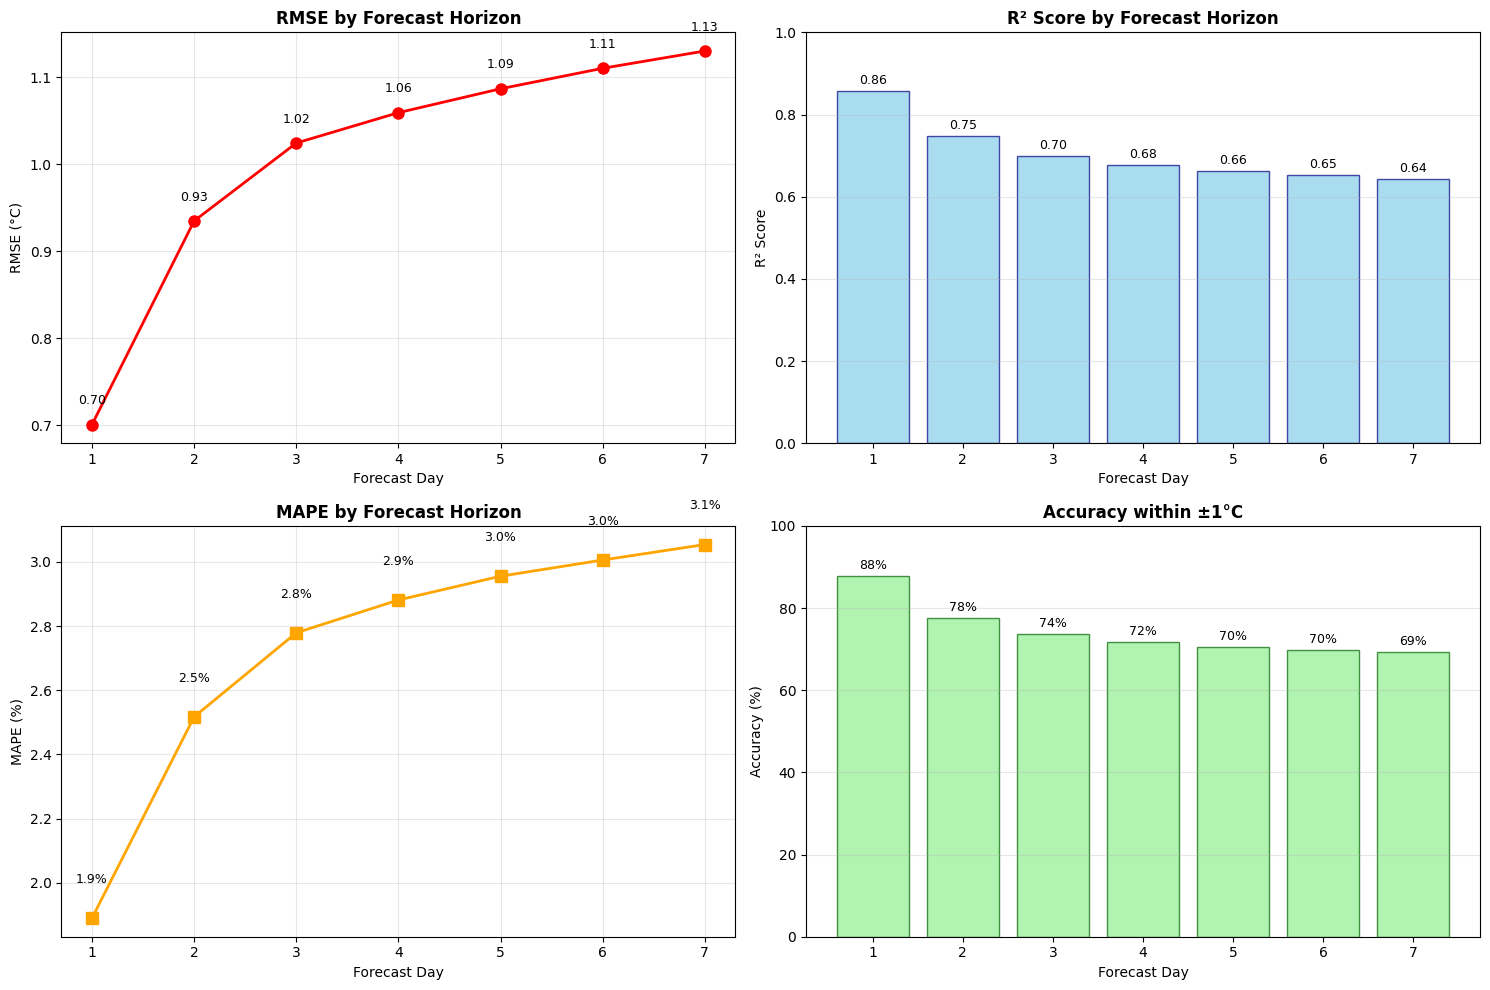

In [25]:
# Visual Performance Analysis
import matplotlib.pyplot as plt

# Create comprehensive performance visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. RMSE by forecast horizon
days = list(range(1, H+1))
rmse_by_day = [sqrt(mean_squared_error(Y_test.iloc[:, h], Y_pred[:, h])) for h in range(H)]

axes[0, 0].plot(days, rmse_by_day, marker='o', linewidth=2, markersize=8, color='red')
axes[0, 0].set_title('RMSE by Forecast Horizon', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Forecast Day')
axes[0, 0].set_ylabel('RMSE (°C)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(days)

# 2. R² Score by forecast horizon
axes[0, 1].bar(days, r2_scores, color='skyblue', alpha=0.7, edgecolor='navy')
axes[0, 1].set_title('R² Score by Forecast Horizon', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Forecast Day')
axes[0, 1].set_ylabel('R² Score')
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].set_xticks(days)
axes[0, 1].set_ylim(0, 1)

# 3. MAPE by forecast horizon
axes[1, 0].plot(days, mape_scores, marker='s', linewidth=2, markersize=8, color='orange')
axes[1, 0].set_title('MAPE by Forecast Horizon', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Forecast Day')
axes[1, 0].set_ylabel('MAPE (%)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(days)

# 4. Accuracy within 1°C tolerance
accuracy_1c = []
for h in range(H):
    actual = Y_test.iloc[:, h]
    predicted = Y_pred[:, h]
    within_tolerance = np.abs(actual - predicted) <= 1.0
    accuracy = (within_tolerance.sum() / len(actual)) * 100
    accuracy_1c.append(accuracy)

axes[1, 1].bar(days, accuracy_1c, color='lightgreen', alpha=0.7, edgecolor='darkgreen')
axes[1, 1].set_title('Accuracy within ±1°C', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Forecast Day')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].set_xticks(days)
axes[1, 1].set_ylim(0, 100)

# Add performance values as text on bars/points
for i, (day, rmse) in enumerate(zip(days, rmse_by_day)):
    axes[0, 0].text(day, rmse + 0.02, f'{rmse:.2f}', ha='center', va='bottom', fontsize=9)

for i, (day, r2) in enumerate(zip(days, r2_scores)):
    axes[0, 1].text(day, r2 + 0.01, f'{r2:.2f}', ha='center', va='bottom', fontsize=9)

for i, (day, mape) in enumerate(zip(days, mape_scores)):
    axes[1, 0].text(day, mape + 0.1, f'{mape:.1f}%', ha='center', va='bottom', fontsize=9)

for i, (day, acc) in enumerate(zip(days, accuracy_1c)):
    axes[1, 1].text(day, acc + 1, f'{acc:.0f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

H = 7

rmse_list = []
mae_list = []
mape_list = []
r2_list = []

for h in range(H):
    y_true_h = Y_test.iloc[:, h]
    y_pred_h = Y_pred[:, h]

    rmse_list.append(np.sqrt(mean_squared_error(y_true_h, y_pred_h)))
    mae_list.append(mean_absolute_error(y_true_h, y_pred_h))
    mape_list.append(mape(y_true_h, y_pred_h))
    r2_list.append(r2_score(y_true_h, y_pred_h))

# ---- Horizontal Display ----
print("==== RMSE ====")
print(" | ".join([f"Day +{i+1}: {rmse_list[i]:.3f}" for i in range(H)]))

print("\n==== MAE ====")
print(" | ".join([f"Day +{i+1}: {mae_list[i]:.3f}" for i in range(H)]))

print("\n==== MAPE (%) ====")
print(" | ".join([f"Day +{i+1}: {mape_list[i]:.2f}%" for i in range(H)]))

print("\n==== R² ====")
print(" | ".join([f"Day +{i+1}: {r2_list[i]:.3f}" for i in range(H)]))

# ---- Accuracy (%) from R² ----
print("\n==== Accuracy (%) from R² ====")
print(" | ".join([f"Day +{i+1}: {r2_list[i]*100:.1f}%" for i in range(H)]))

# ---- Overall metrics ----
rmse_overall = np.sqrt(mean_squared_error(Y_test, Y_pred))
mae_overall = mean_absolute_error(Y_test, Y_pred)
mape_overall = mape(Y_test, Y_pred)
r2_overall = r2_score(Y_test, Y_pred)

print("\n==== Overall ====")
print(f"RMSE={rmse_overall:.3f} | MAE={mae_overall:.3f} | "
      f"MAPE={mape_overall:.2f}% | R²={r2_overall:.3f} | "
      f"Accuracy={(r2_overall*100):.1f}%")

==== RMSE ====
Day +1: 0.701 | Day +2: 0.935 | Day +3: 1.024 | Day +4: 1.059 | Day +5: 1.087 | Day +6: 1.110 | Day +7: 1.130

==== MAE ====
Day +1: 0.528 | Day +2: 0.699 | Day +3: 0.772 | Day +4: 0.800 | Day +5: 0.821 | Day +6: 0.834 | Day +7: 0.847

==== MAPE (%) ====
Day +1: 1.89% | Day +2: 2.52% | Day +3: 2.78% | Day +4: 2.88% | Day +5: 2.96% | Day +6: 3.01% | Day +7: 3.05%

==== R² ====
Day +1: 0.858 | Day +2: 0.748 | Day +3: 0.698 | Day +4: 0.677 | Day +5: 0.663 | Day +6: 0.653 | Day +7: 0.643

==== Accuracy (%) from R² ====
Day +1: 85.8% | Day +2: 74.8% | Day +3: 69.8% | Day +4: 67.7% | Day +5: 66.3% | Day +6: 65.3% | Day +7: 64.3%

==== Overall ====
RMSE=1.016 | MAE=0.757 | MAPE=2.73% | R²=0.706 | Accuracy=70.6%


### Predict 7 days

In [27]:
X_last = df[selected_features].iloc[[-1]] # shape = (1, n_features)
t2m_next7 = model_rf.predict(X_last)[0]

# Get the last date in dataset and generate next 7 days
last_date = pd.to_datetime(df["date"].iloc[-1])
print(f"Last data date: {last_date.strftime('%Y-%m-%d (%A)')}")
print(f"Starting forecast from: {(last_date + pd.Timedelta(days=1)).strftime('%Y-%m-%d (%A)')}")
print()

# Generate forecast with dates
forecast_dates = [last_date + pd.Timedelta(days=i) for i in range(1, 8)]

for i, (date, temp) in enumerate(zip(forecast_dates, t2m_next7), start=1):
    day_name = date.strftime('%A')
    date_str = date.strftime('%Y-%m-%d')
    print(f"Day +{i}: {date_str} ({day_name}) → {temp:.2f}°C")

print(f"\nForecast Range: {t2m_next7.min():.2f}°C to {t2m_next7.max():.2f}°C")
print(f"Average Temperature: {t2m_next7.mean():.2f}°C")

# Temperature trend analysis
temp_trend = "increasing" if t2m_next7[-1] > t2m_next7[0] else "decreasing"
temp_change = abs(t2m_next7[-1] - t2m_next7[0])
print(f"7-day Trend: {temp_trend} ({temp_change:.2f}°C change)")

Last data date: 2025-11-14 (Friday)
Starting forecast from: 2025-11-15 (Saturday)

Day +1: 2025-11-15 (Saturday) → 25.62°C
Day +2: 2025-11-16 (Sunday) → 25.53°C
Day +3: 2025-11-17 (Monday) → 25.42°C
Day +4: 2025-11-18 (Tuesday) → 25.41°C
Day +5: 2025-11-19 (Wednesday) → 25.31°C
Day +6: 2025-11-20 (Thursday) → 25.41°C
Day +7: 2025-11-21 (Friday) → 25.42°C

Forecast Range: 25.31°C to 25.62°C
Average Temperature: 25.44°C
7-day Trend: decreasing (0.20°C change)


### Pattern plot

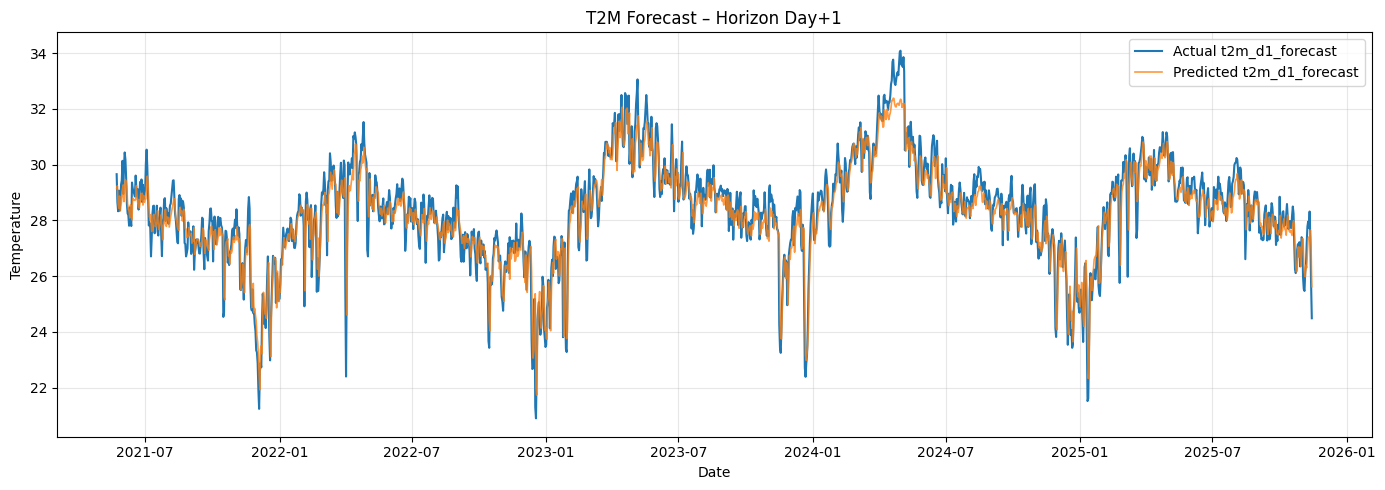

In [28]:
import matplotlib.pyplot as plt

# สร้าง date index สำหรับ test set
dates_test = pd.to_datetime(df["date"].iloc[split_idx:])

# เลือก horizon ที่อยากดู เช่น day+7 = index 6
h = 0   # 0 = day+1, 6 = day+7
target_name = t2m_targets[h]

plt.figure(figsize=(14, 5))
plt.plot(dates_test, Y_test.iloc[:, h], label=f"Actual {target_name}", linewidth=1.5)
plt.plot(dates_test, Y_pred[:, h], label=f"Predicted {target_name}", linewidth=1.2, alpha=0.8)

plt.title(f"T2M Forecast – Horizon Day+{h+1}")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

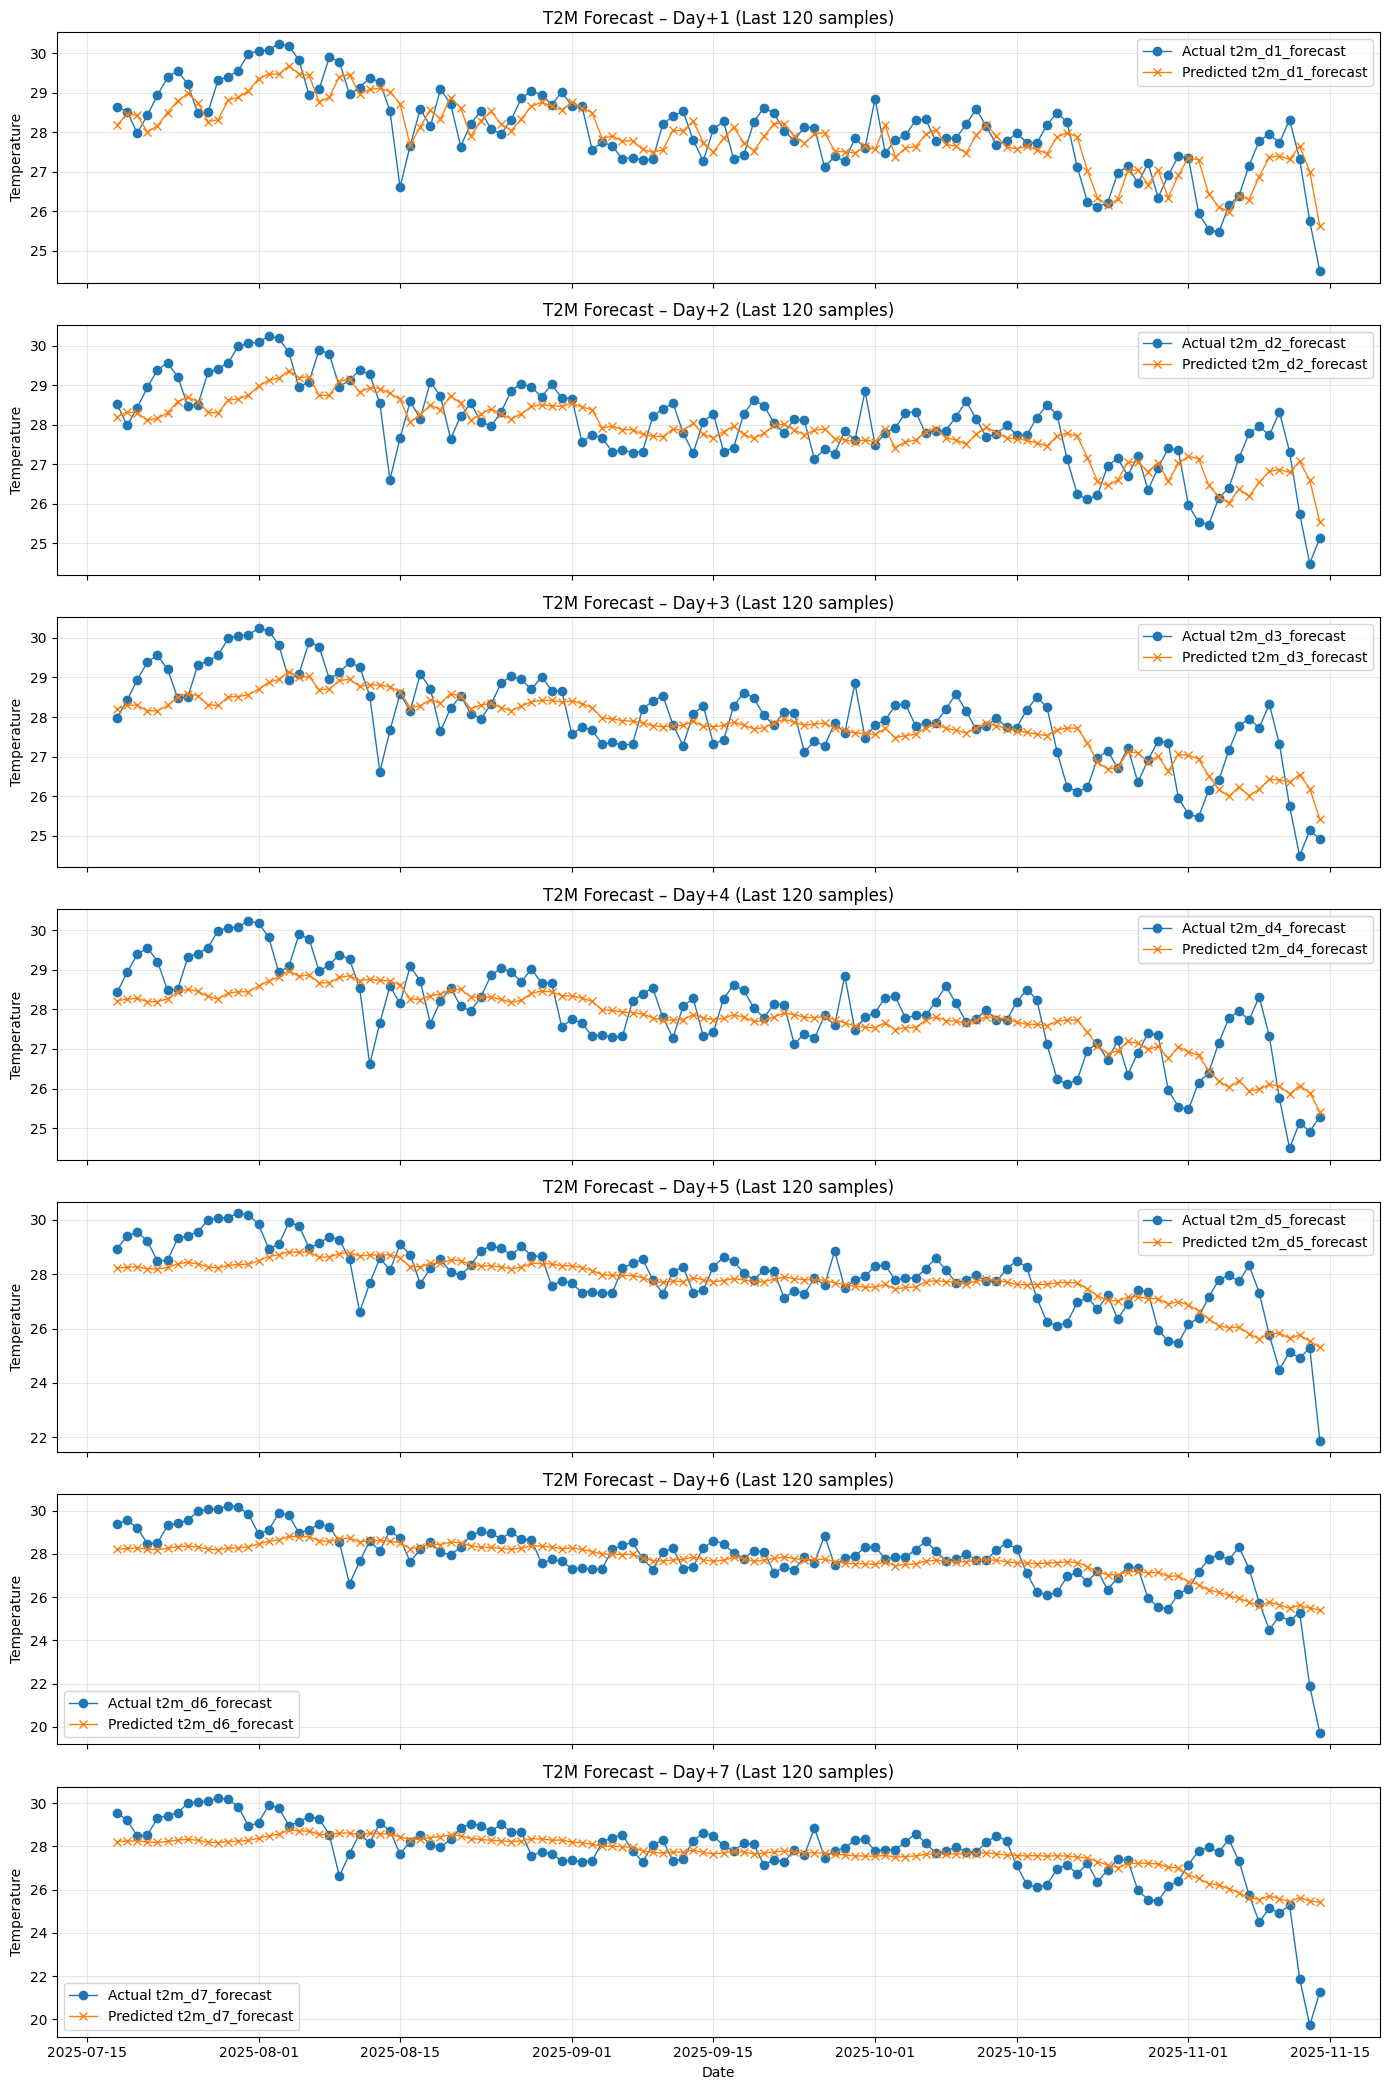

In [29]:
# จำนวนจุดที่อยาก zoom ดู
N = 120  # เช่น 4 เดือนสุดท้าย
days = [f"Day+{i+1}" for i in range(H)]
fig, axs = plt.subplots(H, 1, figsize=(14, 3*H), sharex=True)
for h in range(H):
    dates_zoom = dates_test[-N:]
    y_test_zoom = Y_test.iloc[-N:, h]
    y_pred_zoom = Y_pred[-N:, h]
    axs[h].plot(dates_zoom, y_test_zoom, label=f"Actual {t2m_targets[h]}", marker="o", linewidth=1)
    axs[h].plot(dates_zoom, y_pred_zoom, label=f"Predicted {t2m_targets[h]}", marker="x", linewidth=1)
    axs[h].set_title(f"T2M Forecast – {days[h]} (Last {N} samples)")
    axs[h].set_ylabel("Temperature")
    axs[h].legend()
    axs[h].grid(True, alpha=0.3)
plt.xlabel("Date")
plt.tight_layout()
plt.show()

### Export Weight Model

In [30]:
import joblib

joblib.dump(model_rf, "../Model/Weight/RandomForest_Multi_T2M_Model.joblib")
print("Model exported to Model/Weight/RandomForest_Multi_T2M_Model.joblib")

Model exported to Model/Weight/RandomForest_Multi_T2M_Model.joblib
